# Numerical exercises 04

From shell, inside `/code` directory:
- To compile: `make`

From shell, inside _this_ directory:
- To execute the first program: `./ex1.sh`
- To execute the second program: `./ex2.sh`

There's no need of changing the input files or creating new directories: the scripts provided should take care of everything. The scripts set also the values of the input file. To change the input values the best option could be to modify the scripts themselves.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.style as style 
style.use('tableau-colorblind10')

## Simulating the molecular dynamics in the microcanonical ensemble

### Notes on the theoretical assumptions

Thermodynamics gives a macroscopic description of equilibrium states in which stable matter exists, using few mechanical properties, that specify the state of a system itself made up by $\sim N_A = 6*10^{23}$ degrees of freedom. Statistical mechanics, starting from microscopic interparticles interactions, derives the macroscopic properties of the system. To specify the **microstate** of a system with $N$ degrees of freedom we need $6N$ coordinates (in the phase space),
$(\vec{q}, \vec{p}) =\{q_i, p_i\}_{i=1,2,...,3N} $,
that obey to the canonical equations of motion (Hamilton's equations). Since the microstate that represents the initial condition of a macroscopic system is unknown, we adopt a **probabilistic description**, that is, we fix a parameter, for instance the energy: $H(q, p) = E$. The motion will be bound to happen on a hypersurface of the phase space. 

The assumption is that, given a macrostate, a statistical system, at any time t, is equally likely to be in a large number of distinct microstates. We picture the **ensemble** as a collection of points, one for each possible microstate, that lie in the allowed region of the phase space: a probability density. We assume that time averages do not depend on initial conditions. Then it follows that averaging over all initial conditions (compatible with experimental constraints) is equivalent to averaging over time evolved space coordinates.
Moreover, the **ergodic hypothesis** states that the average behavior of a system in this ensemble of microstates is equal to the time-averaged behaviour of the given system.
We are assuming then that ensemble averages do not depend on time. In fact there is a one to one correspondence between the initial phase space coordinates of a system and those that specify the state of the system at a later time.

To trace the movements of the members of the ensemble in the phase space we define a density function, distribution function $\rho (q, p , t)$. $\rho$ obeys to [Liouville's theorem](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian)): whereas the motion of an individual member of the ensemble is given by Hamilton's equations, Liouville's equations describe the flow of the whole distribution. The motion of the ensemble points in the phase space is analogous to the motion of an incompressible fluid.  Stationary states ($\dot \rho =0 \implies \rho(\vec q, \vec p) = c$) will eliminate the time dependence and represent equilibrium states of the system. In this case the ensemble will be reduced to systems uniformly distributed over all possible microstates, and the ensemble average will be:
$$
\langle f \rangle = \frac{\int_\Omega d^{3N}q d^{3N} p f(\vec q, \vec p )P(\vec q, \vec p)}{Vol(\Omega)}
$$
In our simulations we will work in the **microcanonical ensemble**, characterized by two postulates:
- The density distribution function is a function of the energy of the system: $\rho(\vec q, \vec p)=\rho(H(\vec q,\vec p))$;
- The microstates with the same energy have the same probability.

### Molecular dynamics

To study molecular dynamics (MD) we simulate the time dependent behavior of a system of particles by integrating their equation of motion with appropriate boundary conditions: the output of the simulation will provide information about later time positions and velocities of the atoms in our _numerical sample_. We can use them to _perform measurements_, that is, to compute the values of macroscopic properties exploiting the theory briefly recalled in the above paragraph.

We simulate the dynamics using Hamilton equations until the system reaches stability, that is, the value of macroscopic properties doesn't change (**equilibration** phase):
$$
\dot q_i = \frac{\partial H(q_i, p_i)}{\partial p_i}, \\
\dot p_i = - \frac{\partial H(q_i, p_i)}{\partial q_i}, \\
i=1, 2, ... 3N.
$$
To solve these equations use numerical methods. We can rely on our aproximated solutions, even if it is known from that classical trajectories initially very close diverge exponentially from one another with time ([Lyapunov instability](https://en.wikipedia.org/wiki/Lyapunov_stability)). 

The first thing to choose is the microscopic potential. We select the **Lennard-Jones potential**:
$$
V(r) = 4\epsilon \left[ \left( \frac{\sigma}{r}\right)^{12} - \left( \frac{\sigma}{r}\right)^6 \right].
$$
We apply **periodic boundary conditions** to our system: we replicate the box containing our system to form a lattice. Being the potential short range we apply a **spherical cutoff** $r_c$: the largest contributions to the potential come from neighboring particles anyway. 

 

## Implementation of the code

We choose to integrate the equations of motions with **Verlet algorithm**, a two step method:
$$
\vec {r}(t + \delta t) = 2 \vec{r}(t) - \vec{r}(t - \delta t) + \vec{a}(t) {\delta t}^2, \quad \quad \vec a(t)=\frac{\vec F}{m},
$$
where $\vec r(t)$ is the vector containing the coordinates of all the particles of the system at time t, $\vec a(t)$ is the vector containing all the accelerations. The positions at times $t$ and $t - \delta t$ are needed as an input. The force is computed from the gradient of the Lennard-Jones potential.

The code uses the class `MolecularDynamics` to simulate the behavior of a system of $N$ particles, in a box of volume $V$ and energy $E$: the microcanonical ensemble. The object `MolecularDynamics` can be created using two different constructors. Both of the constructors accept an input file that specifies the physical parameters and the simulation parameters, that can correspond to different states of the matter (solid, liquid, gas). Moreover: 
- the first constructor must be invoked when starting the very first simulation. It takes as an input a file `config.0` describing the initial configuration of the system. We use a fixed configuration (for instance the FCC crystalline configuration) to avoid unlikely (due to Lennard Jones potential) overlaps between particles;
- the second constructor must be invoked in later simulations, since it uses as input files the output files of the previous simulation. It takes as an input two files `config.final` and `old.0` that describe respectively the last, and second to last configuration of the system.

In the first case the initial velocities $\vec v_{rand}$ of the particles are randomly generated and then rescaled in order to obtain a value of temperature compatible with the temperature specified in the input file $T^*$: $\vec v(t)=\sqrt{T^*/T}\vec v_{rand}$. This velocity $\vec v(t)$ is used to estimate the $r(t - \delta t)$ configuration, which is not specified, being this the first simulation, but is needed by the Verlet algorithm. The new "old" configuration of the system $r(t - \delta t)$ is an output of the program, as well as the final configuration $r(t)$ computed with Verlet algorithm. The drawback is that after some steps of the simulation, the velocities of the system tend to stabilize at a different temperature value than the input one, tipically a lower value: due to the scattering between particles, the momentum of the particles is distributed among the system. The Maxwell-Boltzmann ditribution of the velocities tends to be more uniform and therefore describes a lower temperature system. This is the reason behind the implementation of the second constructor, that provides the possibility of **restarting** from the previous configuration. 

Every time the simulation is restarted: 
- another step of the algorithm is computed: from $r(t)$ to $r(t+\delta t)$;
- the velocity $\vec v(t + \delta t/2)$ is computed and rescaled to be compatible with the target temperature value; 
- with it, a new "old" configuration of the system at time $t$ is computed: $\vec r_{new} (t) = \vec r(t+ \delta t) - \vec v(t+\delta t/2) \delta t$, more compatible with the new velocities;
- the restarted simulation can now begin: after some restarts we can obtain a good enough value of temperature for our purposes.

Once reached the target temperature, the Verlet algorithm does not need the velocities of the particles as an input. We get an estimate of them anyway, in order to obtain the values of the macroscopic properties of our system: kinetic energy $\langle K \rangle$, potential energy $\langle V \rangle$, total energy $\langle E_{tot} \rangle$, pressure $P$ and temperature $T$. In our program the estimation of velocities is implemented in the `Move()` method, when a step of Verlet is performed, in the following way: 
$$ 
\vec{v}(t) = \frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2 \delta t}.
$$
The values of the quantities of interest are calculated using the relations known from statistical mechanics. The outputs of the program are given in terms of **reduced units**: $V^\star = V/\epsilon$, $K^\star = K/\epsilon$, $T^\star = k_B T/\epsilon$.

## Exercise 04.1: Instant values and equilibration

The purpose of this exercise is to improve the code we were given in order to add the possibility of restarting our simulation and rescaling the velocities of the particles in the system in order to match the target temperature value. This was done as explained in the paragraph above. Here we present the results of our simulations, with $N_{part}=108$ particles, temporal steps of $\delta t^\star = 0.0005$, a total of $N_{step}=1000$ and the following parameters:

1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

The graphs below exhibit the expected behavior: at the end of the very first simulation the temperature is stable at a value below the target value, in the solid and liquid phase. The restarts "push up" the temperature and after 6 restarts the temperature values matches our goal.


In [2]:
nG=6 #numbers of graphs (max 8)

def suptitle(state):
    if state=="solid": state="Solid"
    elif state=="liquid": state="Liquid"
    elif state=="gas": state="Gas"
    plt.suptitle(state+' State',size='large', weight='bold')
    print()

def state_equil(state,T_des):   #state is "solid", "liquid" or "gas"
    plt.figure(figsize=(16,8))
    step=1
    while step<=nG:

        ekin=np.genfromtxt('ex4.1/'+ state+ '/results'+str(step)+'/output_ekin.dat')
        epot=np.genfromtxt('ex4.1/'+ state+ '/results'+str(step)+'/output_epot.dat')
        etot=np.genfromtxt('ex4.1/'+ state+ '/results'+str(step)+'/output_etot.dat')
        temp=np.genfromtxt('ex4.1/'+ state+ '/results'+str(step)+'/output_temp.dat')
        press=np.genfromtxt('ex4.1/'+ state+ '/results'+str(step)+'/output_press.dat')
        mes=(ekin,epot,etot,temp,press)
        label=('Kinetic Energy','Potential Energy','Total Energy','Temperature','Pressure')
    
        plt.subplot(2,3,step)
        for i in range(5): plt.plot(mes[i],label=label[i])
        plt.axhline(y=T_des,color='k',linewidth=0.8,label='Desired T')
        if(step==1): plt.legend(loc='center left', bbox_to_anchor=(0, 1.35))
        if(step>3): plt.xlabel('$N_{measures}$')
        plt.title('Iteration '+str(step))
        plt.grid(True)    
        step+=1
    
    suptitle(state)
    plt.show()
    
state_equil("solid",0.8)
state_equil("liquid",1.1)
state_equil("gas",1.2)

OSError: ex4.1/solid/results1/output_ekin.dat not found.

<Figure size 1152x576 with 0 Axes>

## Exercise 04.2 & 04.3: Argon simulations with blocking averages

The code can also compute the blocking averages and errors of the thermodynamics quantities of interest. The number of blocks can be specified in the input file. The system was equilibrated thanks to 6 restarts, each of $N_{step}=1000$, then the results below were obtained through a simulation evolved in time for $N_{step}=100000$ steps. Since the system is already equilibrated, every measure is equivalent, and so the use of the blocking method is justified. In our results the blocks are $N_{blocks}=100$. As done in previous exercises, the averages and the errors in the graphs are in function of the number of blocks used to compute them.

The advantage of using the reduced units is that at the moment of the conversion to SI units the same results can describe different physical systems. This is known as the **law of corresponding states**. Here the results are converted from the reduced units to the **SI units** in order to describe a system of **Argon** atoms: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu.

We can observe in the graphs below that the total energy has very small fluctuations: it means that the algorithm conserves the total energy of the system very well. 

### Optional exercise: calculating the pressure

The value of the pressure is calculated as well, both istantaneous and the averaged with uncertainties, using the **virial theorem** applied to a Lennard-Jones potential.

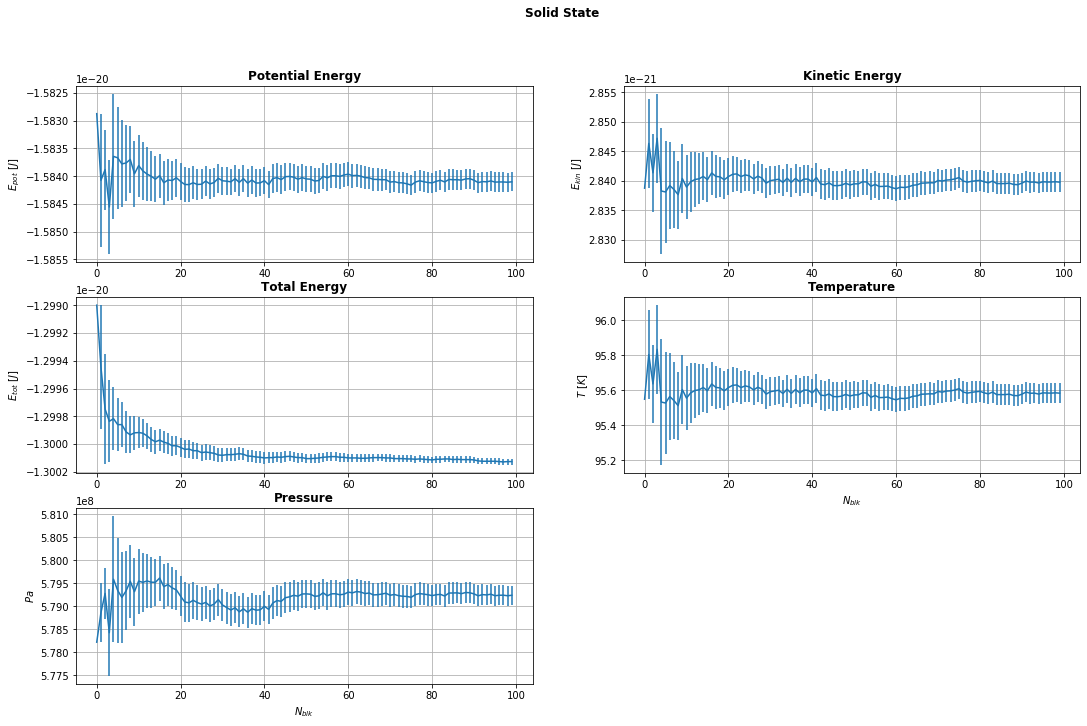

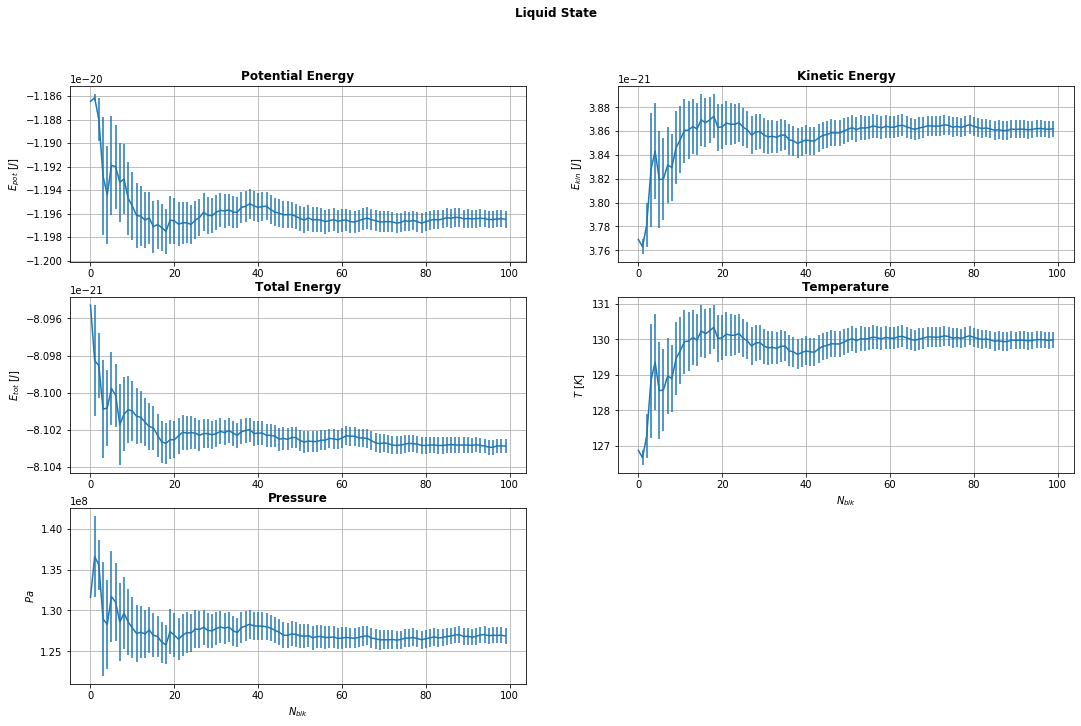

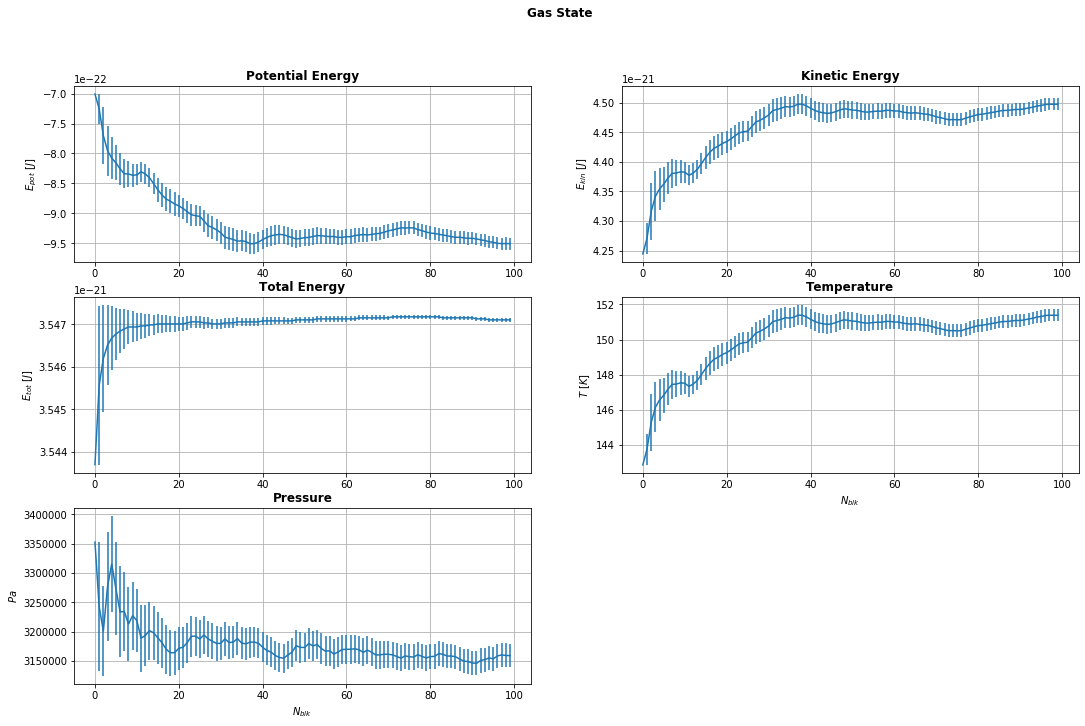

In [4]:

kB,eps_kB,sigma=1.98064852e-23,120,0.34;        #Boltzmann constant, eps/kB
eps=eps_kB*kB;
sigma_si=sigma*1E-9;

def state_meas(state):            
    
    Ekin=np.genfromtxt('ex4.2/'+state+'/results/ave_ekin.dat',usecols=(0,1,2),names='x,res,err')
    Epot=np.genfromtxt('ex4.2/'+state+'/results/ave_epot.dat',usecols=(0,1,2),names='x,res,err')
    Etot=np.genfromtxt('ex4.2/'+state+'/results/ave_etot.dat',usecols=(0,1,2),names='x,res,err')
    temp=np.genfromtxt('ex4.2/'+state+'/results/ave_temp.dat',usecols=(0,1,2),names='x,res,err')
    press=np.genfromtxt('ex4.2/'+state+'/results/ave_press.dat',usecols=(0,1,2),names='x,res,err')

    mes=[Epot,Ekin,Etot,temp, press]
    y_lab=['$E_{pot}$','$E_{kin}$','$E_{tot}$','$T$', '$P$']
    title=('Potential Energy','Kinetic Energy','Total Energy','Temperature','Pressure')
    #conversion in real unit, explicit in the labels
    for i in range(3): mes[i]['res']*=eps; mes[i]['err']*=eps; y_lab[i]+='$\ [J]$'
    temp['res']*=eps_kB; temp['err']*=eps_kB; y_lab[3]+='$\ [K]$'; 
    press['res']*=eps/(sigma_si**3); press['err']*=eps/(sigma_si**3); y_lab[4]='$Pa$'

    plt.figure(figsize=(18,11))
    for i in range(5):
        plt.subplot(3,2,i+1)
        plt.errorbar(mes[i]['x'],mes[i]['res'],yerr=mes[i]['err'])
        if i>2: plt.xlabel('$N_{blk}$')
        plt.ylabel(y_lab[i])
        plt.title(title[i],size='large', weight='bold')
        plt.grid(True)        
        
    suptitle(state)
    plt.show()
    
state_meas("solid")
state_meas("liquid")
state_meas("gas")